TASK 1 - 2

# Task 1

In [717]:
#imports
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

In [718]:
# load target
target = np.load("target_1.npy")


# define time horizon
T = len(target[0])

In [719]:
#define constants
A = np.array([[1, 0, 0.1, 0], [0, 1, 0, 0.1], [0, 0, 0.8, 0], [0, 0, 0, 0.8]])

B = np.array([[0, 0], [0, 0], [0.1, 0], [0, 0.1]])

E = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

In [720]:
# create cp variables
x = cp.Variable((4, T))
u = cp.Variable((2, T - 1))

In [721]:
# Tracking Error
TE = cp.sum([cp.norm(E @ x[:, t] - target[:, t], 2) for t in range(T)])

# Control Effort
CE = cp.sum_squares(u[:, : T - 1])

In [722]:
# define constraints
constraints = [x[:, 0] == np.array([0.5, 0, 1, -1])]

for t in range(T - 1):
    constraints += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t]]

In [723]:
# result storage
results = []

# define objective
rho = 10
TE_results = []
CE_results = []
for rho in [10, 5, 2, 1, 0.5, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002]:
    objective = cp.Minimize(TE + rho * CE)
    prob = cp.Problem(objective, constraints)
    prob.solve()
    TE_results.append(TE.value)
    CE_results.append(CE.value)
    results.append((rho, x[0].value, x[1].value))

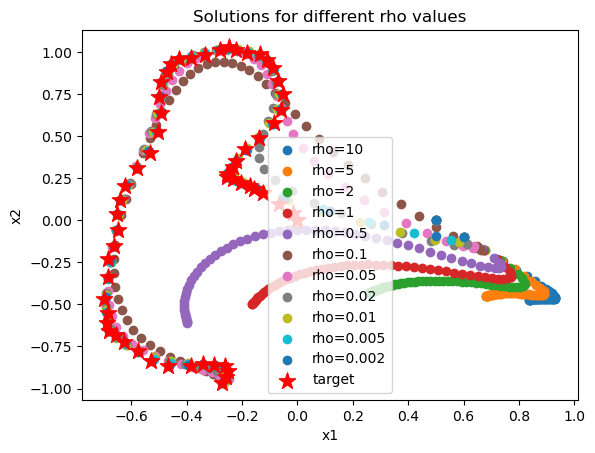

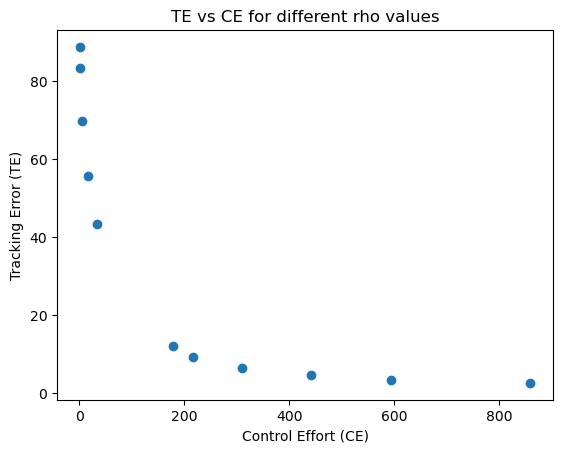

In [724]:
# plot tracking results
plt.figure()
for rho, x1, x2 in results:
    plt.scatter(x1, x2, label=f"rho={rho}")  # scatter is better for points

# plot target as a red star
plt.scatter(target[0], target[1], color="red", marker="*", s=150, label="target")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Solutions for different rho values")
plt.legend()
plt.savefig("solutions_plot.png", dpi=500)  # can also use .pdf, .svg, etc.

# plot TE vs CE
plt.figure()
plt.scatter(CE_results, TE_results)

plt.xlabel("Control Effort (CE)")
plt.ylabel("Tracking Error (TE)")
plt.title("TE vs CE for different rho values")
plt.savefig("TE_vs_CE_plot.png", dpi=500)
plt.show()

# Task 2

## Proof by Contradiction 

We want to solve the minimization problem with cost function  

$$f_{\rho} (x, u) = \sum_{t=1}^{T} \left \lVert Ex(t) - q(t) \right \rVert_2 + \sum_{t=1}^{T} \left \lVert u(t) \right \rVert_2 ^2$$

which gives the optimal pair $(x^*, u^*)$ that minimizes the cost.  

Let us denote by:  

- $TE_{\rho}^*$ the optimal tracking error at parameter $\rho$,  
- $CE_{\rho}^*$ the optimal control effort at parameter $\rho$.  

If $(x_a^*, u_a^*)$ is optimal for $\rho_a$:  

$TE_{\rho_a}^* + \rho_a \cdot CE_{\rho_a}^* <= TE_{\rho_b}^* + \rho_a \cdot CE_{\rho_b}^*$ (1)

Similarly, if $(x_b^*, u_b^*)$ is optimal for $\rho_b$, then 

$TE_{\rho_b}^* + \rho_b \cdot CE_{\rho_b}^* <= TE_{\rho_a}^* + \rho_b \cdot CE_{\rho_a}^*$ (2)

Define:
- $\Delta TE = TE_{\rho_b}^* - TE_{\rho_A}^*$
- $\Delta CE = CE_{\rho_b}^* - CE_{\rho_a}^*$

Premisses: 
- $TE_{\rho_a}^* \leq TE_{\rho_b}^* \rightarrow \Delta TE \geq 0$
- $\rho_a > 0$ 
- $\rho_b > 0$


Suppose $CE_{\rho_b} > CE_{\rho_a}$, which implies $\Delta CE > 0$. It holds true for the first equation, but equation (2) $\Delta CE = CE_{\rho_b}^* - CE_{\rho_a}^*$ would then require $\Delta CE <= 0$, which cannot be true because both terms are nonnegative and at least one is strictly positive.

This contradiction shows that the assumption $\Delta CE > 0$ is false. Therefore, $\Delta CE \leq 0$

$$CE_{\rho_a} \geq CE_{\rho_b}$$

# Task 3

We start with the system dynamics:
- for $t = 1 \Rightarrow x(1) = x_{initial}$ 
- for $t = 2 \Rightarrow x(2) = Ax_{initial} + Bu(1)$ 
- for $t = 3 \Rightarrow x(2) = A^2 x_{initial} + ABu(1) + Bu(2)$ 

So a general function for x(t) is 

$$x(t) = A^{t-1}x_{initial} + \sum_{k=1}^{t-1} A^{t-1-k}Bu(k)  $$

Hence the tracking error at time (t) is

$$\left \{ \begin{array}{l} Ex(t) + q(t) = c(t) + \sum_{k=1}^{t-1} g(k)u(k) \\ c(t) = EA^{t-1}x_{initial} - q(t) \\  g(k) = A^{t-1-k}B \end{array} \right .$$

Stacking over the horizon, let
- $z = \begin{pmatrix} Ex(1) - q(1) \\ Ex(2) - q(2) \\ \vdots \\ Ex(T) - q(T) \end{pmatrix} $
- $c = \begin{pmatrix} c(1) \\ c(2)) \\ \vdots \\ c(T) \end{pmatrix} $
- $u = \begin{pmatrix} u(1) \\ u(2)) \\ \vdots \\ u(T) \end{pmatrix} $

then, $z = c + Gu$, where G is a lower triangle matrix: $G = \begin{bmatrix}
0 & 0 & 0 & \cdots & 0 \\
g(2,1) & 0 & 0 & \cdots & 0 \\
g(3,1) & g(3,2) & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \vdots \\
g(T,1) & g(T,2) & \cdots & g(T,T-1) & 0
\end{bmatrix}.$

The tracking error term is
$
TE = \sum_{t=1}^T |Ex(t) - q(t)|_2^2 = |z|_2^2 = |c + Gu|_2^2,
$
which is a convex quadratic function of (u).

The control effort term is
$
CE = \sum_{t=1}^T |u(t)|_2^2 = |u|_2^2,
$
which is strongly convex in (u).

Therefore, the full cost is $ f_\rho(u) = |c + Gu|_2^2 + \rho |u|_2^2, \rho > 0.$ which is a strong convex function. Therefore the minimization problem has a unique solution.

# Task 4

In [725]:
# load target
target_1 = np.load("target_1.npy")
target_2 = np.load("target_2.npy")


# define time horizon
T = len(target_1[0])

In [726]:
# Tracking Error
TE_1 = cp.sum([cp.norm(E @ x[:, t] - target_1[:, t], 2) for t in range(T)])
TE_2 = cp.sum([cp.norm(E @ x[:, t] - target_2[:, t], 2) for t in range(T)])

# Control Effort
CE = cp.sum_squares(u[:, : T - 1])

In [727]:
# result storage
results = []

# define objective
rho = 10
TE_1_results = []
TE_2_results = []
CE_results = []
rho = 0.1

for p1, p2 in [(0,1) ,(0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1), (1,0)]:
    objective = cp.Minimize(p1*TE_1 + p2*TE_2 + rho * CE)
    prob = cp.Problem(objective, constraints)
    prob.solve()
    TE_1_results.append(TE_1.value)
    TE_2_results.append(TE_2.value)
    CE_results.append(CE.value)
    results.append((p1, x[0].value, x[1].value))

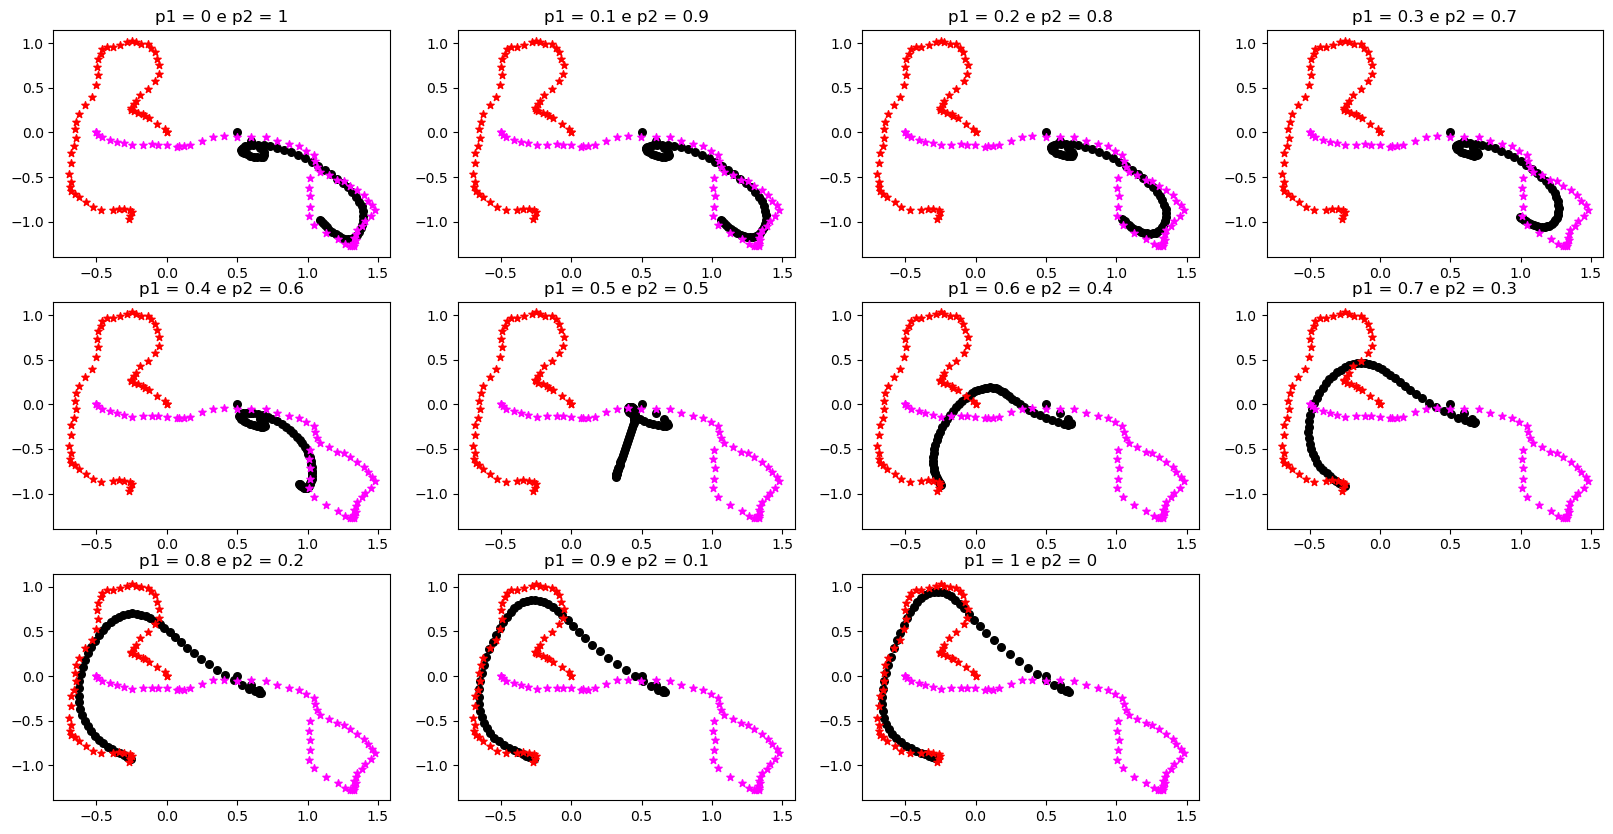

In [728]:
# plot tracking results
plt.figure(figsize=(20,10))
for i, (p1, x1, x2) in enumerate(results):
    plt.subplot(3,4,i+1)
    plt.title(f"p1 = {p1} e p2 = {round(1-p1,1)}")
    plt.scatter(x1, x2, color="black", s=30)
    plt.scatter(target_1[0], target_1[1], color="red", marker="*", s=30, label="target_1")
    plt.scatter(target_2[0], target_2[1], color="magenta", marker="*", s=30, label="target_2")